## Prepare Data

Import libraries:

In [1]:
import numpy as np
import pickle
import cv2
import tensorflow as tf
import random
import csv
import glob 
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Process Default Data

Process default data file:

In [39]:
default_csv = './default_data/driving_log.csv'
path = './default_data/'

car_images = []
steering_angles = []

# Get first track csv data
with open(default_csv) as csv_file:
    reader = csv.reader(csv_file)
    
    for row in reader:
            
        steering_center = float(row[3])

        # create adjusted steering measurements for the side camera images
        correction = 0.2 # this is a parameter to tune
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        # read in images from center, left and right cameras
        img_center = cv2.imread(path + row[0].strip())
        img_left = cv2.imread(path + row[1].strip())
        img_right = cv2.imread(path + row[2].strip())
        
        img_center = cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB)
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
        
        # add images and angles to data set
        car_images.extend([img_center, img_left, img_right])
        steering_angles.extend([steering_center, steering_left, steering_right])

Save training data:

In [40]:
# Build training data set
X_train_d = np.array(car_images)
y_train_d = np.array(steering_angles)

MemoryError: 

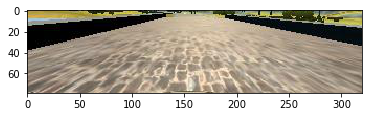

In [51]:
plt.imshow(car_images[0][60:-21,:, :])

In [6]:
default_train_data = {"features" : X_train_d,"labels" : y_train_d}
pickle.dump(default_train_data, open( "default_train.p", "wb" ))

MemoryError: 

## Process Recorded Data

Process CSV measurements file:

In [2]:
# Tracks directories
first_track = './data/first_track'
second_track = './data/second_track'

log_file = 'driving_log.csv'
imgs_folder = 'IMG'
log_csv = []

# List used to skip some data
valid_folders = ['center_lane_1', 
                 'curves_smoothly_1_f_1', 
                 'curves_smoothly_1_f_2', 
                 'recovery_1',
                 'center_lane_2', 
                 'curves_smoothly_2_f', 
                 'recovery_2']

# Get first track csv data
for file in os.listdir(first_track):
#     if file in valid_folders:
    # Build CSV path
    csv_path = "{}/{}/{}".format(first_track, file, log_file)

    # Load CSV data
    with open(csv_path) as csv_file:
        reader = csv.reader(csv_file)
        for line in reader:
            log_csv.append(line)

# Get second track csv data
for file in os.listdir(second_track):
#     if file in valid_folders:
        
    # Build CSV path
    csv_path = "{}/{}/{}".format(second_track, file, log_file)

    # Load CSV data
    with open(csv_path) as csv_file:
        reader = csv.reader(csv_file)
        for line in reader:
            log_csv.append(line)

print(len(log_csv))

21895


In [6]:
images = []
measurements = []

for line in log_csv:
    # Get image path
    source_path = line[0]
    # Get image name
    file_name = source_path.split('/')[-1]
    # Change image path 
    current_path = './data/IMG/' + file_name
    # Store Image
    image = cv2.imread(current_path)
    images.append(image)
    
    # Store Steering Angle
    measurement = float(line[3])
    measurements.append(measurement)

# Build training data set
X_train = np.array(images)
y_train = np.array(measurements)

print(len(X_train))
print(len(y_train))

5315
5315


Store Training Data:

In [26]:
train_data = {"features" : X_train,"labels" : y_train}
pickle.dump(train_data, open( "train.p", "wb" ))

Loading Data:

In [2]:
with open("train.p", "rb") as train_file:
    train_data = pickle.load(train_file)
    
X_train, y_train = train_data["features"], train_data["labels"]

## Building Models

### Simplest Model Possible

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax, Adadelta, Adagrad, Adam, SGD, RMSprop

Using TensorFlow backend.


Simplest Model Try Out:

In [30]:
m1 = Sequential()
m1.add(Flatten(input_shape=(160, 320, 3)))
m1.add(Dense(1))

m1.compile(loss='mse', optimizer='adam')
m1.fit(X_train, y_train, validation_split=0.2, shuffle=True)

m1.save('m1.h5')

Train on 17516 samples, validate on 4379 samples
Epoch 1/10
17516/17516 [==============================] - 20s - loss: 1633333.1567 - val_loss: 1195.7598
Epoch 2/10
17516/17516 [==============================] - 20s - loss: 2928.4181 - val_loss: 8850.5901
Epoch 3/10
17516/17516 [==============================] - 20s - loss: 154086.9365 - val_loss: 19758618.6120
Epoch 4/10
17516/17516 [==============================] - 20s - loss: 559733.1857 - val_loss: 4464.4862
Epoch 5/10
17516/17516 [==============================] - 20s - loss: 374218.4078 - val_loss: 25923.1692
Epoch 6/10
17516/17516 [==============================] - 20s - loss: 292226.3216 - val_loss: 54597.8005
Epoch 7/10
17516/17516 [==============================] - 20s - loss: 203483.8062 - val_loss: 45812.6437
Epoch 8/10
17516/17516 [==============================] - 20s - loss: 414011.9327 - val_loss: 5974.0142
Epoch 9/10
17516/17516 [==============================] - 20s - loss: 355963.7128 - val_loss: 73384.6647
Epoch 10

### Normalization

Normalize Images in Range: 0 - 1

In [28]:
m2 = Sequential()
m2.add(Lambda(lambda x: x / 255.0, input_shape=(160, 320, 3)))
m2.add(Flatten())
m2.add(Dense(1))

m2.compile(loss='mse', optimizer='adam')
m2.fit(X_train, y_train, validation_split=0.2, shuffle=True)

m2.save('m2.h5')

Train on 17516 samples, validate on 4379 samples
Epoch 1/10
17516/17516 [==============================] - 20s - loss: 25.9219 - val_loss: 0.1310
Epoch 2/10
17516/17516 [==============================] - 20s - loss: 0.1302 - val_loss: 0.1292
Epoch 3/10
17516/17516 [==============================] - 21s - loss: 3.3529 - val_loss: 0.4656
Epoch 4/10
17516/17516 [==============================] - 20s - loss: 4.8874 - val_loss: 0.1863
Epoch 5/10
17516/17516 [==============================] - 21s - loss: 7.0445 - val_loss: 0.2356
Epoch 6/10
17516/17516 [==============================] - 21s - loss: 3.0626 - val_loss: 2.8542
Epoch 7/10
17516/17516 [==============================] - 20s - loss: 5.9324 - val_loss: 7.9464
Epoch 8/10
17516/17516 [==============================] - 20s - loss: 5.2262 - val_loss: 0.7999
Epoch 9/10
17516/17516 [==============================] - 20s - loss: 5.8150 - val_loss: 0.2200
Epoch 10/10
17516/17516 [==============================] - 20s - loss: 3.7678 - val_lo

Mean Center Images:

In [31]:
m3 = Sequential()
m3.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
m3.add(Flatten())
m3.add(Dense(1))

m3.compile(loss='mse', optimizer='adam')
m3.fit(X_train, y_train, validation_split=0.2, shuffle=True)

m3.save('m3.h5')

Train on 17516 samples, validate on 4379 samples
Epoch 1/10
17516/17516 [==============================] - 21s - loss: 4.4784 - val_loss: 16.1374
Epoch 2/10
17516/17516 [==============================] - 21s - loss: 1.9974 - val_loss: 8.7859
Epoch 3/10
17516/17516 [==============================] - 21s - loss: 3.7621 - val_loss: 1.8375
Epoch 4/10
17516/17516 [==============================] - 21s - loss: 4.2360 - val_loss: 0.4352
Epoch 5/10
17516/17516 [==============================] - 21s - loss: 2.3698 - val_loss: 5.8420
Epoch 6/10
17516/17516 [==============================] - 21s - loss: 5.0843 - val_loss: 1.3734
Epoch 7/10
17516/17516 [==============================] - 21s - loss: 1.8498 - val_loss: 7.1161
Epoch 8/10
17516/17516 [==============================] - 21s - loss: 3.4522 - val_loss: 4.0788s: 3.454
Epoch 9/10
17516/17516 [==============================] - 21s - loss: 3.1270 - val_loss: 2.9286
Epoch 10/10
17516/17516 [==============================] - 21s - loss: 1.5077 

### LeNet Model

![](https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/09/lenet-5.png?x64257)
![](http://gpucomputing.shef.ac.uk/static/img/intro_dl_sharc_dgx1/mnist_lenet.jpg)

In [9]:
lenet = Sequential()
lenet.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
lenet.add(Convolution2D(6, 5, 5, activation='relu'))
lenet.add(MaxPooling2D())
lenet.add(Convolution2D(6, 5, 5, activation='relu'))
lenet.add(MaxPooling2D())
lenet.add(Flatten())
lenet.add(Dense(120))
lenet.add(Dense(84))
lenet.add(Dense(1))


lenet.compile(loss='mse', optimizer='adam')
lenet.fit(X_train_d, y_train_d, validation_split=0.2, shuffle=True)

lenet.save('lenet.h5')

Train on 19286 samples, validate on 4822 samples
Epoch 1/10
19286/19286 [==============================] - 71s - loss: 0.3134 - val_loss: 0.0153
Epoch 2/10
19286/19286 [==============================] - 70s - loss: 0.0109 - val_loss: 0.0118
Epoch 3/10
19286/19286 [==============================] - 69s - loss: 0.0082 - val_loss: 0.0120
Epoch 4/10
19286/19286 [==============================] - 70s - loss: 0.0071 - val_loss: 0.0119
Epoch 5/10
19286/19286 [==============================] - 70s - loss: 0.0064 - val_loss: 0.0127
Epoch 6/10
19286/19286 [==============================] - 70s - loss: 0.0058 - val_loss: 0.0134
Epoch 7/10
19286/19286 [==============================] - 70s - loss: 0.0055 - val_loss: 0.0136
Epoch 8/10
19286/19286 [==============================] - 70s - loss: 0.0051 - val_loss: 0.0143
Epoch 9/10
19286/19286 [==============================] - 70s - loss: 0.0049 - val_loss: 0.0136
Epoch 10/10
19286/19286 [==============================] - 68s - loss: 0.0046 - val_los

## Image Augmentation

Flipping Images Vertically

In [4]:
X_aug, y_aug = [], []

for X, y in zip(X_train_d, y_train_d):
    X_aug.append(X)
    y_aug.append(y)
    X_aug.append(cv2.flip(X, 1))
    y_aug.append(y * -1.0)

In [6]:
X_aug, y_aug = np.array(X_aug), np.array(y_aug)

MemoryError: 

Store Augmented Data

In [9]:
aug_data = {"features" : X_aug,"labels" : y_aug}
pickle.dump(aug_data, open( "train_aug.p", "wb" ))

(43790, 160, 320, 3)


In [14]:
lenet_aug = Sequential()
lenet_aug.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
lenet_aug.add(Lambda(lambda x: x / 255.0 - 0.5))
lenet_aug.add(Convolution2D(6, 5, 5, activation='relu'))
lenet_aug.add(MaxPooling2D())
lenet_aug.add(Convolution2D(6, 5, 5, activation='relu'))
lenet_aug.add(MaxPooling2D())
lenet_aug.add(Flatten())
lenet_aug.add(Dense(120))
lenet_aug.add(Dense(84))
lenet_aug.add(Dense(1))

lenet_aug.compile(loss='mse', optimizer='adam')
lenet_aug.fit(X_train_d, y_train_d, validation_split=0.2, shuffle=True)

lenet_aug.save('lenet_default_train.h5')

Train on 19286 samples, validate on 4822 samples
Epoch 1/10
19286/19286 [==============================] - 49s - loss: 0.0682 - val_loss: 0.0214
Epoch 2/10
19286/19286 [==============================] - 46s - loss: 0.0142 - val_loss: 0.0208
Epoch 3/10
19286/19286 [==============================] - 46s - loss: 0.0119 - val_loss: 0.0187
Epoch 4/10
19286/19286 [==============================] - 46s - loss: 0.0106 - val_loss: 0.0180
Epoch 5/10
19286/19286 [==============================] - 46s - loss: 0.0098 - val_loss: 0.0195
Epoch 6/10
19286/19286 [==============================] - 46s - loss: 0.0090 - val_loss: 0.0175
Epoch 7/10
19286/19286 [==============================] - 46s - loss: 0.0086 - val_loss: 0.0184
Epoch 8/10
19286/19286 [==============================] - 47s - loss: 0.0083 - val_loss: 0.0184
Epoch 9/10
19286/19286 [==============================] - 46s - loss: 0.0081 - val_loss: 0.0190
Epoch 10/10
19286/19286 [==============================] - 46s - loss: 0.0077 - val_los

## Nvidia End to End Model

<img src="https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/08/cnn-architecture.png" alt="Nvidia Network" style="width: 500px;"/>

In [33]:
nvidia = Sequential()
nvidia.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
nvidia.add(Cropping2D(cropping=((70,25), (0,0))))
nvidia.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
nvidia.add(Dropout(0.5))
nvidia.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
nvidia.add(Dropout(0.5))
nvidia.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
nvidia.add(Dropout(0.5))
nvidia.add(Convolution2D(64, 3, 3, activation='relu'))
nvidia.add(Dropout(0.5))
nvidia.add(Convolution2D(64, 3, 3, activation='relu'))
nvidia.add(Dropout(0.5))
nvidia.add(Flatten())
nvidia.add(Dense(100))
nvidia.add(Dropout(0.5))
nvidia.add(Dense(50))
nvidia.add(Dropout(0.5))
nvidia.add(Dense(10))
nvidia.add(Dense(1))

# Adamax, Adadelta, Adagrad, Adam, SGD, RMSprop
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999)

nvidia.compile(loss='mse', optimizer=opt,  metrics=['accuracy'])

filepath="nividia-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = nvidia.fit(X_train_d, y_train_d, validation_split=0.2, batch_size=128, nb_epoch=5, callbacks=callbacks_list, shuffle=True)

nvidia.save('nvidia_model.h5')

Train on 19286 samples, validate on 4822 samples
Epoch 1/5
19286/19286 [==============================] - 69s - loss: 0.0447 - acc: 0.1799 - val_loss: 0.0442 - val_acc: 0.1837
Epoch 2/5
19286/19286 [==============================] - 41s - loss: 0.0356 - acc: 0.1798 - val_loss: 0.0317 - val_acc: 0.1837
Epoch 3/5
19286/19286 [==============================] - 41s - loss: 0.0284 - acc: 0.1800 - val_loss: 0.0310 - val_acc: 0.1837
Epoch 4/5
19286/19286 [==============================] - 41s - loss: 0.0243 - acc: 0.1799 - val_loss: 0.0237 - val_acc: 0.1837
Epoch 5/5
19286/19286 [==============================] - 41s - loss: 0.0226 - acc: 0.1801 - val_loss: 0.0213 - val_acc: 0.1837


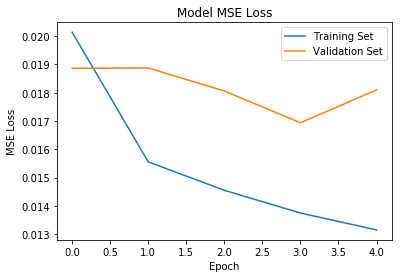

In [28]:
### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model MSE Loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper right')
plt.show()

In [9]:
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax, Adadelta, Adagrad, Adam, SGD, RMSprop

samples = []
with open('./default_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# log_csv
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

data_path = './default_data' # ./data
ty = 40
dy = -20

def generator(samples, batch_size=32, colour_space='RGB'):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                
                # Get Images Path
                center_name = data_path + '/IMG/' + batch_sample[0].split('/')[-1].strip()
                left_name = data_path + '/IMG/' + batch_sample[1].split('/')[-1].strip()
                right_name = data_path + '/IMG/'+ batch_sample[1].split('/')[-1].strip()
                
                # Read images from center, left and right cameras
                center_image = cv2.imread(center_name)
                left_image = cv2.imread(left_name)
                right_image = cv2.imread(right_name)
                
                if colour_space == 'RGB':
                    colour_conv = cv2.COLOR_BGR2RGB
                else:
                    colour_conv = cv2.COLOR_BGR2GRAY
                    
                # Convert Colour Space
                center_image = cv2.cvtColor(center_image, colour_conv)
                left_image = cv2.cvtColor(left_image, colour_conv)
                right_image = cv2.cvtColor(right_image, colour_conv)
                
                if colour_space != 'RGB':
                    center_image = np.reshape(center_image, (center_image.shape[0], center_image.shape[1], 1))
                    left_image = np.reshape(left_image, (center_image.shape[0], center_image.shape[1], 1))
                    right_image = np.reshape(right_image, (center_image.shape[0], center_image.shape[1], 1))
        
                center_image = center_image[ty:dy,:, :]
                left_image = left_image[ty:dy,:, :]
                right_image = right_image[ty:dy,:, :]
                
                # Augment Images
                center_image_flip = cv2.flip(center_image, 1)
                left_image_flip = cv2.flip(left_image, 1)
                right_image_flip = cv2.flip(right_image, 1)
                
                if colour_space != 'RGB':
                    center_image_flip = np.reshape(center_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    left_image_flip = np.reshape(left_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    right_image_flip = np.reshape(right_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                

                # Get Measurements
                center_angle = float(batch_sample[3])
                # Create adjusted steering measurements for the side camera images
                correction = 0.1 # this is a parameter to tune
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                # Augment Measurements
                center_angle_flip = center_angle * -1.0
                left_angle_flip = left_angle * -1.0
                right_angle_flip = right_angle * -1.0
                
                
                center_image = cv2.resize(center_image, (200, 66), interpolation=cv2.INTER_AREA)
                left_image = cv2.resize(left_image, (200, 66), interpolation=cv2.INTER_AREA)
                right_image = cv2.resize(right_image, (200, 66), interpolation=cv2.INTER_AREA)
                center_image_flip = cv2.resize(center_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                left_image_flip = cv2.resize(left_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                right_image_flip = cv2.resize(right_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                
                
                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)
                
                images.append(center_image_flip)
                angles.append(center_angle_flip)
                images.append(left_image_flip)
                angles.append(left_angle_flip)
                images.append(right_image_flip)
                angles.append(right_angle_flip)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

In [5]:
# compile and train the model using the generator function

train_generator = generator(train_samples, batch_size=32, colour_space='RGB')
validation_generator = generator(validation_samples, batch_size=32, colour_space='RGB')

ngen = Sequential()

ngen.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 200, 3)))

# k_init = TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
keep_prob = 0.2

ngen.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
ngen.add(Dropout(keep_prob))
ngen.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
ngen.add(Dropout(keep_prob))
ngen.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
ngen.add(Dropout(keep_prob))
ngen.add(Convolution2D(64, 3, 3, activation='relu'))
ngen.add(Dropout(keep_prob))
ngen.add(Convolution2D(64, 3, 3, activation='relu'))
ngen.add(Dropout(keep_prob))

ngen.add(Flatten())
ngen.add(Dense(100))
ngen.add(Dropout(keep_prob))
ngen.add(Dense(50))
ngen.add(Dropout(keep_prob))
ngen.add(Dense(10))
ngen.add(Dropout(keep_prob))
ngen.add(Dense(1))

ngen.load_weights("ngen-improvement-00-0.05.hdf5")
ngen.compile(loss='mse', optimizer='adam',  metrics=['accuracy'])

filepath="ngen-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

n_cameras = 3
n_augmentations = 2

ngen.fit_generator(train_generator, 
                     samples_per_epoch=len(train_samples) * n_cameras * n_augmentations, 
                     validation_data=validation_generator, 
                     nb_val_samples=len(validation_samples) * n_cameras * n_augmentations, 
                     nb_epoch=17,
                     callbacks=callbacks_list)

ngen.save('ngen_model.h5')

Epoch 1/17
105096/105096 [==============================] - 137s - loss: 0.0569 - acc: 0.1868 - val_loss: 0.0501 - val_acc: 0.1881
Epoch 2/17
105096/105096 [==============================] - 136s - loss: 0.0547 - acc: 0.1870 - val_loss: 0.0503 - val_acc: 0.1880
Epoch 3/17
105096/105096 [==============================] - 135s - loss: 0.0534 - acc: 0.1872 - val_loss: 0.0489 - val_acc: 0.1885
Epoch 4/17
105096/105096 [==============================] - 135s - loss: 0.0525 - acc: 0.1876 - val_loss: 0.0495 - val_acc: 0.1885
Epoch 5/17
105096/105096 [==============================] - 135s - loss: 0.0518 - acc: 0.1873 - val_loss: 0.0479 - val_acc: 0.1886
Epoch 6/17
105096/105096 [==============================] - 135s - loss: 0.0509 - acc: 0.1877 - val_loss: 0.0485 - val_acc: 0.1885
Epoch 7/17
105096/105096 [==============================] - 136s - loss: 0.0507 - acc: 0.1876 - val_loss: 0.0474 - val_acc: 0.1886
Epoch 8/17
105096/105096 [==============================] - 136s - loss: 0.0495 - a

In [8]:
train_generator = generator(train_samples, batch_size=32, colour_space='RGB')
validation_generator = generator(validation_samples, batch_size=32, colour_space='RGB')

ngen.load_weights("ngen-improvement-16-0.05.hdf5")
ngen.compile(loss='mse', optimizer='adam',  metrics=['accuracy'])

filepath="ngen-improvement-all{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

n_cameras = 3
n_augmentations = 2

ngen.fit_generator(train_generator, 
                     samples_per_epoch=len(train_samples) * n_cameras * n_augmentations, 
                     validation_data=validation_generator, 
                     nb_val_samples=len(validation_samples) * n_cameras * n_augmentations, 
                     nb_epoch=17,
                     callbacks=callbacks_list)

ngen.save('ngen_model_trained_on_all_sets.h5')

Epoch 1/17
38568/38568 [==============================] - 51s - loss: 0.0172 - acc: 0.1798 - val_loss: 0.0163 - val_acc: 0.1851
Epoch 2/17
38568/38568 [==============================] - 49s - loss: 0.0167 - acc: 0.1798 - val_loss: 0.0161 - val_acc: 0.1851
Epoch 3/17
38568/38568 [==============================] - 48s - loss: 0.0166 - acc: 0.1798 - val_loss: 0.0161 - val_acc: 0.1851
Epoch 4/17
38568/38568 [==============================] - 49s - loss: 0.0164 - acc: 0.1798 - val_loss: 0.0160 - val_acc: 0.1851
Epoch 5/17
38568/38568 [==============================] - 48s - loss: 0.0163 - acc: 0.1798 - val_loss: 0.0160 - val_acc: 0.1851
Epoch 6/17
38568/38568 [==============================] - 48s - loss: 0.0162 - acc: 0.1798 - val_loss: 0.0159 - val_acc: 0.1851
Epoch 7/17
38568/38568 [==============================] - 48s - loss: 0.0161 - acc: 0.1798 - val_loss: 0.0158 - val_acc: 0.1851
Epoch 8/17
38568/38568 [==============================] - 48s - loss: 0.0160 - acc: 0.1798 - val_loss: 0

### ALL with New Data

In [4]:
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax, Adadelta, Adagrad, Adam, SGD, RMSprop

samples = []
with open('./new_data/driving_log_1.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
with open('./new_data/driving_log_2.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# log_csv
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

data_path = './new_data' # ./data
ty = 40
dy = -20

def generator(samples, batch_size=32, colour_space='RGB'):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                
                # Get Images Path
                center_name = data_path + '/IMG/' + batch_sample[0].split('/')[-1].strip()
                left_name = data_path + '/IMG/' + batch_sample[1].split('/')[-1].strip()
                right_name = data_path + '/IMG/'+ batch_sample[1].split('/')[-1].strip()
                
                # Read images from center, left and right cameras
                center_image = cv2.imread(center_name)
                left_image = cv2.imread(left_name)
                right_image = cv2.imread(right_name)
                
                if colour_space == 'RGB':
                    colour_conv = cv2.COLOR_BGR2RGB
                else:
                    colour_conv = cv2.COLOR_BGR2GRAY
                    
                # Convert Colour Space
                center_image = cv2.cvtColor(center_image, colour_conv)
                left_image = cv2.cvtColor(left_image, colour_conv)
                right_image = cv2.cvtColor(right_image, colour_conv)
                
                if colour_space != 'RGB':
                    center_image = np.reshape(center_image, (center_image.shape[0], center_image.shape[1], 1))
                    left_image = np.reshape(left_image, (center_image.shape[0], center_image.shape[1], 1))
                    right_image = np.reshape(right_image, (center_image.shape[0], center_image.shape[1], 1))
        
                center_image = center_image[ty:dy,:, :]
                left_image = left_image[ty:dy,:, :]
                right_image = right_image[ty:dy,:, :]
                
                # Augment Images
                center_image_flip = cv2.flip(center_image, 1)
                left_image_flip = cv2.flip(left_image, 1)
                right_image_flip = cv2.flip(right_image, 1)
                
                if colour_space != 'RGB':
                    center_image_flip = np.reshape(center_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    left_image_flip = np.reshape(left_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    right_image_flip = np.reshape(right_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                

                # Get Measurements
                center_angle = float(batch_sample[3])
                # Create adjusted steering measurements for the side camera images
                correction = 0.1 # this is a parameter to tune
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                # Augment Measurements
                center_angle_flip = center_angle * -1.0
                left_angle_flip = left_angle * -1.0
                right_angle_flip = right_angle * -1.0
                
                
                center_image = cv2.resize(center_image, (200, 66), interpolation=cv2.INTER_AREA)
                left_image = cv2.resize(left_image, (200, 66), interpolation=cv2.INTER_AREA)
                right_image = cv2.resize(right_image, (200, 66), interpolation=cv2.INTER_AREA)
                center_image_flip = cv2.resize(center_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                left_image_flip = cv2.resize(left_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                right_image_flip = cv2.resize(right_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                
                
                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)
                
                images.append(center_image_flip)
                angles.append(center_angle_flip)
                images.append(left_image_flip)
                angles.append(left_angle_flip)
                images.append(right_image_flip)
                angles.append(right_angle_flip)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

In [ ]:
train_generator = generator(train_samples, batch_size=32, colour_space='RGB')
validation_generator = generator(validation_samples, batch_size=32, colour_space='RGB')

ngen = Sequential()

ngen.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 200, 3)))

# k_init = TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
keep_prob = 0.2

ngen.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
ngen.add(Dropout(keep_prob))
ngen.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
ngen.add(Dropout(keep_prob))
ngen.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
ngen.add(Dropout(keep_prob))
ngen.add(Convolution2D(64, 3, 3, activation='relu'))
ngen.add(Dropout(keep_prob))
ngen.add(Convolution2D(64, 3, 3, activation='relu'))
ngen.add(Dropout(keep_prob))

ngen.add(Flatten())
ngen.add(Dense(100))
ngen.add(Dropout(keep_prob))
ngen.add(Dense(50))
ngen.add(Dropout(keep_prob))
ngen.add(Dense(10))
ngen.add(Dropout(keep_prob))
ngen.add(Dense(1))


ngen.load_weights("./models/ngen_model_trained_on_all_sets.h5")
ngen.compile(loss='mse', optimizer='adam',  metrics=['accuracy'])

filepath="ngen-new-data{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

n_cameras = 3
n_augmentations = 2

ngen.fit_generator(train_generator, 
                     samples_per_epoch=len(train_samples) * n_cameras * n_augmentations, 
                     validation_data=validation_generator, 
                     nb_val_samples=len(validation_samples) * n_cameras * n_augmentations, 
                     nb_epoch=17,
                     callbacks=callbacks_list)

ngen.save('ngen_new_data.h5')

Epoch 1/17
20736/73488 [=======>......................] - ETA: 122s - loss: 0.0340 - acc: 0.0062
Epoch 3/17
73488/73488 [==============================] - 91s - loss: 0.0234 - acc: 0.0066 - val_loss: 0.0187 - val_acc: 0.0069
Epoch 4/17
73488/73488 [==============================] - 91s - loss: 0.0224 - acc: 0.0066 - val_loss: 0.0182 - val_acc: 0.0069
Epoch 5/17
73488/73488 [==============================] - 91s - loss: 0.0216 - acc: 0.0066 - val_loss: 0.0178 - val_acc: 0.0069
Epoch 6/17
73488/73488 [==============================] - 91s - loss: 0.0210 - acc: 0.0066 - val_loss: 0.0175 - val_acc: 0.0069
Epoch 7/17
73488/73488 [==============================] - 91s - loss: 0.0205 - acc: 0.0066 - val_loss: 0.0165 - val_acc: 0.0069
Epoch 8/17
73488/73488 [==============================] - 91s - loss: 0.0201 - acc: 0.0066 - val_loss: 0.0166 - val_acc: 0.0069
Epoch 9/17
73488/73488 [==============================] - 91s - loss: 0.0197 - acc: 0.0066 - val_loss: 0.0161 - val_acc: 0.0069
Epoch 1

### Default Data Model

Using default data for training

In [1]:
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax, Adadelta, Adagrad, Adam, SGD, RMSprop

default_samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        default_samples.append(line)

# log_csv
train_samples, validation_samples = train_test_split(default_samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

data_path = './data' # ./data
ty = 40
dy = -20

def generator(samples, batch_size=32, colour_space='RGB'):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                
                # Get Images Path
                center_name = data_path + '/IMG/' + batch_sample[0].split('/')[-1].strip()
                left_name = data_path + '/IMG/' + batch_sample[1].split('/')[-1].strip()
                right_name = data_path + '/IMG/'+ batch_sample[1].split('/')[-1].strip()
                
                # Read images from center, left and right cameras
                center_image = cv2.imread(center_name)
                left_image = cv2.imread(left_name)
                right_image = cv2.imread(right_name)
                
                if colour_space == 'RGB':
                    colour_conv = cv2.COLOR_BGR2RGB
                else:
                    colour_conv = cv2.COLOR_BGR2GRAY
                    
                # Convert Colour Space
                center_image = cv2.cvtColor(center_image, colour_conv)
                left_image = cv2.cvtColor(left_image, colour_conv)
                right_image = cv2.cvtColor(right_image, colour_conv)
                
                if colour_space != 'RGB':
                    center_image = np.reshape(center_image, (center_image.shape[0], center_image.shape[1], 1))
                    left_image = np.reshape(left_image, (center_image.shape[0], center_image.shape[1], 1))
                    right_image = np.reshape(right_image, (center_image.shape[0], center_image.shape[1], 1))
        
                center_image = center_image[ty:dy,:, :]
                left_image = left_image[ty:dy,:, :]
                right_image = right_image[ty:dy,:, :]
                
                # Augment Images
                center_image_flip = cv2.flip(center_image, 1)
                left_image_flip = cv2.flip(left_image, 1)
                right_image_flip = cv2.flip(right_image, 1)
                
                if colour_space != 'RGB':
                    center_image_flip = np.reshape(center_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    left_image_flip = np.reshape(left_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    right_image_flip = np.reshape(right_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                

                # Get Measurements
                center_angle = float(batch_sample[3])
                # Create adjusted steering measurements for the side camera images
                correction = 0.1 # this is a parameter to tune
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                # Augment Measurements
                center_angle_flip = center_angle * -1.0
                left_angle_flip = left_angle * -1.0
                right_angle_flip = right_angle * -1.0
                
                
                center_image = cv2.resize(center_image, (200, 66), interpolation=cv2.INTER_AREA)
                left_image = cv2.resize(left_image, (200, 66), interpolation=cv2.INTER_AREA)
                right_image = cv2.resize(right_image, (200, 66), interpolation=cv2.INTER_AREA)
                center_image_flip = cv2.resize(center_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                left_image_flip = cv2.resize(left_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                right_image_flip = cv2.resize(right_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                
                
                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)
                
                images.append(center_image_flip)
                angles.append(center_angle_flip)
                images.append(left_image_flip)
                angles.append(left_angle_flip)
                images.append(right_image_flip)
                angles.append(right_angle_flip)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

Using TensorFlow backend.


In [2]:
train_generator = generator(train_samples, batch_size=256, colour_space='RGB')
validation_generator = generator(validation_samples, batch_size=256, colour_space='RGB')

default = Sequential()

default.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 200, 3)))

# k_init = TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
keep_prob = 0.2

default.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
default.add(Dropout(keep_prob))
default.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
default.add(Dropout(keep_prob))
default.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
default.add(Dropout(keep_prob))
default.add(Convolution2D(64, 3, 3, activation='relu'))
default.add(Dropout(keep_prob))
default.add(Convolution2D(64, 3, 3, activation='relu'))
default.add(Dropout(keep_prob))

default.add(Flatten())
default.add(Dense(100))
default.add(Dropout(keep_prob))
default.add(Dense(50))
default.add(Dropout(keep_prob))
default.add(Dense(10))
default.add(Dropout(keep_prob))
default.add(Dense(1))

default.compile(loss='mse', optimizer='adam',  metrics=['accuracy'])

filepath="default-intermediate-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

n_cameras = 3
n_augmentations = 2

default.fit_generator(train_generator, 
                     samples_per_epoch=len(train_samples) * n_cameras * n_augmentations, 
                     validation_data=validation_generator, 
                     nb_val_samples=len(validation_samples) * n_cameras * n_augmentations, 
                     nb_epoch=17,
                     callbacks=callbacks_list)

default.save('default_model.h5')

Epoch 1/17
38568/38568 [==============================] - 54s - loss: 0.0284 - acc: 0.1806 - val_loss: 0.0215 - val_acc: 0.1814
Epoch 2/17
38568/38568 [==============================] - 46s - loss: 0.0208 - acc: 0.1808 - val_loss: 0.0175 - val_acc: 0.1814
Epoch 3/17
38568/38568 [==============================] - 46s - loss: 0.0187 - acc: 0.1808 - val_loss: 0.0169 - val_acc: 0.1814
Epoch 4/17
38568/38568 [==============================] - 46s - loss: 0.0181 - acc: 0.1808 - val_loss: 0.0167 - val_acc: 0.1814
Epoch 5/17
38568/38568 [==============================] - 46s - loss: 0.0177 - acc: 0.1808 - val_loss: 0.0169 - val_acc: 0.1814
Epoch 6/17
38568/38568 [==============================] - 46s - loss: 0.0177 - acc: 0.1808 - val_loss: 0.0163 - val_acc: 0.1814
Epoch 7/17
38568/38568 [==============================] - 47s - loss: 0.0174 - acc: 0.1808 - val_loss: 0.0166 - val_acc: 0.1814
Epoch 8/17
38568/38568 [==============================] - 46s - loss: 0.0173 - acc: 0.1808 - val_loss: 0

NameError: name 'ngen' is not defined

### New Data Model

Use New Data for Training

In [1]:
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax, Adadelta, Adagrad, Adam, SGD, RMSprop

samples = []
with open('./new_data/driving_log_1.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
with open('./new_data/driving_log_2.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# log_csv
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

data_path = './new_data' # ./data
ty = 40
dy = -20

def generator(samples, batch_size=32, colour_space='RGB'):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                
                # Get Images Path
                center_name = data_path + '/IMG/' + batch_sample[0].split('/')[-1].strip()
                left_name = data_path + '/IMG/' + batch_sample[1].split('/')[-1].strip()
                right_name = data_path + '/IMG/'+ batch_sample[1].split('/')[-1].strip()
                
                # Read images from center, left and right cameras
                center_image = cv2.imread(center_name)
                left_image = cv2.imread(left_name)
                right_image = cv2.imread(right_name)
                
                if colour_space == 'RGB':
                    colour_conv = cv2.COLOR_BGR2RGB
                else:
                    colour_conv = cv2.COLOR_BGR2GRAY
                    
                # Convert Colour Space
                center_image = cv2.cvtColor(center_image, colour_conv)
                left_image = cv2.cvtColor(left_image, colour_conv)
                right_image = cv2.cvtColor(right_image, colour_conv)
                
                if colour_space != 'RGB':
                    center_image = np.reshape(center_image, (center_image.shape[0], center_image.shape[1], 1))
                    left_image = np.reshape(left_image, (center_image.shape[0], center_image.shape[1], 1))
                    right_image = np.reshape(right_image, (center_image.shape[0], center_image.shape[1], 1))
        
                center_image = center_image[ty:dy,:, :]
                left_image = left_image[ty:dy,:, :]
                right_image = right_image[ty:dy,:, :]
                
                # Augment Images
                center_image_flip = cv2.flip(center_image, 1)
                left_image_flip = cv2.flip(left_image, 1)
                right_image_flip = cv2.flip(right_image, 1)
                
                if colour_space != 'RGB':
                    center_image_flip = np.reshape(center_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    left_image_flip = np.reshape(left_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    right_image_flip = np.reshape(right_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                

                # Get Measurements
                center_angle = float(batch_sample[3])
                # Create adjusted steering measurements for the side camera images
                correction = 0.1 # this is a parameter to tune
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                # Augment Measurements
                center_angle_flip = center_angle * -1.0
                left_angle_flip = left_angle * -1.0
                right_angle_flip = right_angle * -1.0
                
                
                center_image = cv2.resize(center_image, (200, 66), interpolation=cv2.INTER_AREA)
                left_image = cv2.resize(left_image, (200, 66), interpolation=cv2.INTER_AREA)
                right_image = cv2.resize(right_image, (200, 66), interpolation=cv2.INTER_AREA)
                center_image_flip = cv2.resize(center_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                left_image_flip = cv2.resize(left_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                right_image_flip = cv2.resize(right_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                
                
                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)
                
                images.append(center_image_flip)
                angles.append(center_angle_flip)
                images.append(left_image_flip)
                angles.append(left_angle_flip)
                images.append(right_image_flip)
                angles.append(right_angle_flip)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

Using TensorFlow backend.


In [3]:
train_generator = generator(train_samples, batch_size=200, colour_space='RGB')
validation_generator = generator(validation_samples, batch_size=200, colour_space='RGB')

new_data = Sequential()

new_data.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 200, 3)))

# k_init = TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
keep_prob = 0.2

new_data.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
new_data.add(Dropout(keep_prob))
new_data.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
new_data.add(Dropout(keep_prob))
new_data.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
new_data.add(Dropout(keep_prob))
new_data.add(Convolution2D(64, 3, 3, activation='relu'))
new_data.add(Dropout(keep_prob))
new_data.add(Convolution2D(64, 3, 3, activation='relu'))
new_data.add(Dropout(keep_prob))

new_data.add(Flatten())
new_data.add(Dense(100))
new_data.add(Dropout(keep_prob))
new_data.add(Dense(50))
new_data.add(Dropout(keep_prob))
new_data.add(Dense(10))
new_data.add(Dropout(keep_prob))
new_data.add(Dense(1))

new_data.load_weights("./new-data-model06-0.02.hdf5")
new_data.compile(loss='mse', optimizer='adam',  metrics=['accuracy'])


filepath="new-data-model-2-try{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

n_cameras = 3
n_augmentations = 2

new_data.fit_generator(train_generator, 
                     samples_per_epoch=len(train_samples) * n_cameras * n_augmentations, 
                     validation_data=validation_generator, 
                     nb_val_samples=len(validation_samples) * n_cameras * n_augmentations, 
                     nb_epoch=8,
                     callbacks=callbacks_list)


Epoch 1/8
73488/73488 [==============================] - 96s - loss: 0.0231 - acc: 0.0069 - val_loss: 0.0184 - val_acc: 0.0057
Epoch 2/8
73488/73488 [==============================] - 85s - loss: 0.0215 - acc: 0.0069 - val_loss: 0.0174 - val_acc: 0.0057
Epoch 3/8
73488/73488 [==============================] - 85s - loss: 0.0211 - acc: 0.0069 - val_loss: 0.0174 - val_acc: 0.0057
Epoch 4/8
73488/73488 [==============================] - 86s - loss: 0.0206 - acc: 0.0069 - val_loss: 0.0173 - val_acc: 0.0057
Epoch 5/8
73488/73488 [==============================] - 85s - loss: 0.0200 - acc: 0.0069 - val_loss: 0.0169 - val_acc: 0.0057
Epoch 6/8
73488/73488 [==============================] - 86s - loss: 0.0197 - acc: 0.0069 - val_loss: 0.0167 - val_acc: 0.0057
Epoch 7/8
73488/73488 [==============================] - 86s - loss: 0.0190 - acc: 0.0069 - val_loss: 0.0161 - val_acc: 0.0057
Epoch 8/8
73488/73488 [==============================] - 86s - loss: 0.0187 - acc: 0.0069 - val_loss: 0.0156 - 

### Default & New Data Model

Train default with new data:


In [5]:
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax, Adadelta, Adagrad, Adam, SGD, RMSprop

samples = []
with open('./new_data/driving_log_1.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
with open('./new_data/driving_log_2.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# log_csv
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

data_path = './new_data' # ./data
ty = 40
dy = -20

def generator(samples, batch_size=32, colour_space='RGB'):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                
                # Get Images Path
                center_name = data_path + '/IMG/' + batch_sample[0].split('/')[-1].strip()
                left_name = data_path + '/IMG/' + batch_sample[1].split('/')[-1].strip()
                right_name = data_path + '/IMG/'+ batch_sample[1].split('/')[-1].strip()
                
                # Read images from center, left and right cameras
                center_image = cv2.imread(center_name)
                left_image = cv2.imread(left_name)
                right_image = cv2.imread(right_name)
                
                if colour_space == 'RGB':
                    colour_conv = cv2.COLOR_BGR2RGB
                else:
                    colour_conv = cv2.COLOR_BGR2GRAY
                    
                # Convert Colour Space
                center_image = cv2.cvtColor(center_image, colour_conv)
                left_image = cv2.cvtColor(left_image, colour_conv)
                right_image = cv2.cvtColor(right_image, colour_conv)
                
                if colour_space != 'RGB':
                    center_image = np.reshape(center_image, (center_image.shape[0], center_image.shape[1], 1))
                    left_image = np.reshape(left_image, (center_image.shape[0], center_image.shape[1], 1))
                    right_image = np.reshape(right_image, (center_image.shape[0], center_image.shape[1], 1))
        
                center_image = center_image[ty:dy,:, :]
                left_image = left_image[ty:dy,:, :]
                right_image = right_image[ty:dy,:, :]
                
                # Augment Images
                center_image_flip = cv2.flip(center_image, 1)
                left_image_flip = cv2.flip(left_image, 1)
                right_image_flip = cv2.flip(right_image, 1)
                
                if colour_space != 'RGB':
                    center_image_flip = np.reshape(center_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    left_image_flip = np.reshape(left_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    right_image_flip = np.reshape(right_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                

                # Get Measurements
                center_angle = float(batch_sample[3])
                # Create adjusted steering measurements for the side camera images
                correction = 0.1 # this is a parameter to tune
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                # Augment Measurements
                center_angle_flip = center_angle * -1.0
                left_angle_flip = left_angle * -1.0
                right_angle_flip = right_angle * -1.0
                
                
                center_image = cv2.resize(center_image, (200, 66), interpolation=cv2.INTER_AREA)
                left_image = cv2.resize(left_image, (200, 66), interpolation=cv2.INTER_AREA)
                right_image = cv2.resize(right_image, (200, 66), interpolation=cv2.INTER_AREA)
                center_image_flip = cv2.resize(center_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                left_image_flip = cv2.resize(left_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                right_image_flip = cv2.resize(right_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                
                
                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)
                
                images.append(center_image_flip)
                angles.append(center_angle_flip)
                images.append(left_image_flip)
                angles.append(left_angle_flip)
                images.append(right_image_flip)
                angles.append(right_angle_flip)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

In [6]:
train_generator = generator(train_samples, batch_size=128, colour_space='RGB')
validation_generator = generator(validation_samples, batch_size=128, colour_space='RGB')

default_new_data = Sequential()

default_new_data.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 200, 3)))

# k_init = TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
keep_prob = 0.2

default_new_data.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
default_new_data.add(Dropout(keep_prob))
default_new_data.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
default_new_data.add(Dropout(keep_prob))
default_new_data.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
default_new_data.add(Dropout(keep_prob))
default_new_data.add(Convolution2D(64, 3, 3, activation='relu'))
default_new_data.add(Dropout(keep_prob))
default_new_data.add(Convolution2D(64, 3, 3, activation='relu'))
default_new_data.add(Dropout(keep_prob))

default_new_data.add(Flatten())
default_new_data.add(Dense(100))
default_new_data.add(Dropout(keep_prob))
default_new_data.add(Dense(50))
default_new_data.add(Dropout(keep_prob))
default_new_data.add(Dense(10))
default_new_data.add(Dropout(keep_prob))
default_new_data.add(Dense(1))

default_new_data.load_weights("./default-intermediate-14-0.02.hdf5")
default_new_data.compile(loss='mse', optimizer='adam',  metrics=['accuracy'])

filepath="default-new-data-model{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

n_cameras = 3
n_augmentations = 2

default_new_data.fit_generator(train_generator, 
                     samples_per_epoch=len(train_samples) * n_cameras * n_augmentations, 
                     validation_data=validation_generator, 
                     nb_val_samples=len(validation_samples) * n_cameras * n_augmentations, 
                     nb_epoch=17,
                     callbacks=callbacks_list)


Epoch 1/17
73488/73488 [==============================] - 94s - loss: 0.0393 - acc: 0.0066 - val_loss: 0.0294 - val_acc: 0.0057
Epoch 2/17
73488/73488 [==============================] - 86s - loss: 0.0288 - acc: 0.0067 - val_loss: 0.0244 - val_acc: 0.0060
Epoch 3/17
73488/73488 [==============================] - 86s - loss: 0.0257 - acc: 0.0068 - val_loss: 0.0225 - val_acc: 0.0060
Epoch 4/17
73488/73488 [==============================] - 86s - loss: 0.0240 - acc: 0.0068 - val_loss: 0.0207 - val_acc: 0.0060
Epoch 5/17
73488/73488 [==============================] - 86s - loss: 0.0227 - acc: 0.0068 - val_loss: 0.0206 - val_acc: 0.0060
Epoch 6/17
73488/73488 [==============================] - 86s - loss: 0.0215 - acc: 0.0068 - val_loss: 0.0193 - val_acc: 0.0060
Epoch 7/17
73488/73488 [==============================] - 86s - loss: 0.0208 - acc: 0.0068 - val_loss: 0.0189 - val_acc: 0.0060
Epoch 8/17
73488/73488 [==============================] - 87s - loss: 0.0204 - acc: 0.0068 - val_loss: 0

### Training best model with 4th training set

Sets used in transfer learning: 1st 1GB Keyboard Set, Default Set, 2nd 700MB Mouse Set, 3rd 700MB Mouse Set


In [2]:
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax, Adadelta, Adagrad, Adam, SGD, RMSprop

samples = []
with open('./data_4/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
with open('./data_4/driving_log_2.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# log_csv
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

data_path = './data_4' # ./data
ty = 40
dy = -20

def generator(samples, batch_size=32, colour_space='RGB'):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                
                # Get Images Path
                center_name = data_path + '/IMG/' + batch_sample[0].split('/')[-1].strip()
                left_name = data_path + '/IMG/' + batch_sample[1].split('/')[-1].strip()
                right_name = data_path + '/IMG/'+ batch_sample[1].split('/')[-1].strip()
                
                # Read images from center, left and right cameras
                center_image = cv2.imread(center_name)
                left_image = cv2.imread(left_name)
                right_image = cv2.imread(right_name)
                
                if colour_space == 'RGB':
                    colour_conv = cv2.COLOR_BGR2RGB
                else:
                    colour_conv = cv2.COLOR_BGR2GRAY
                    
                # Convert Colour Space
                center_image = cv2.cvtColor(center_image, colour_conv)
                left_image = cv2.cvtColor(left_image, colour_conv)
                right_image = cv2.cvtColor(right_image, colour_conv)
                
                if colour_space != 'RGB':
                    center_image = np.reshape(center_image, (center_image.shape[0], center_image.shape[1], 1))
                    left_image = np.reshape(left_image, (center_image.shape[0], center_image.shape[1], 1))
                    right_image = np.reshape(right_image, (center_image.shape[0], center_image.shape[1], 1))
        
                center_image = center_image[ty:dy,:, :]
                left_image = left_image[ty:dy,:, :]
                right_image = right_image[ty:dy,:, :]
                
                # Augment Images
                center_image_flip = cv2.flip(center_image, 1)
                left_image_flip = cv2.flip(left_image, 1)
                right_image_flip = cv2.flip(right_image, 1)
                
                if colour_space != 'RGB':
                    center_image_flip = np.reshape(center_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    left_image_flip = np.reshape(left_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    right_image_flip = np.reshape(right_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                

                # Get Measurements
                center_angle = float(batch_sample[3])
                # Create adjusted steering measurements for the side camera images
                correction = 0.1 # this is a parameter to tune
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                # Augment Measurements
                center_angle_flip = center_angle * -1.0
                left_angle_flip = left_angle * -1.0
                right_angle_flip = right_angle * -1.0
                
                
                center_image = cv2.resize(center_image, (200, 66), interpolation=cv2.INTER_AREA)
                left_image = cv2.resize(left_image, (200, 66), interpolation=cv2.INTER_AREA)
                right_image = cv2.resize(right_image, (200, 66), interpolation=cv2.INTER_AREA)
                center_image_flip = cv2.resize(center_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                left_image_flip = cv2.resize(left_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                right_image_flip = cv2.resize(right_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                
                
                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)
                
                images.append(center_image_flip)
                angles.append(center_angle_flip)
                images.append(left_image_flip)
                angles.append(left_angle_flip)
                images.append(right_image_flip)
                angles.append(right_angle_flip)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

Using TensorFlow backend.


In [3]:
train_generator = generator(train_samples, batch_size=128, colour_space='RGB')
validation_generator = generator(validation_samples, batch_size=128, colour_space='RGB')

bm = Sequential()

bm.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 200, 3)))

# k_init = TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
keep_prob = 0.2

bm.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
bm.add(Dropout(keep_prob))
bm.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
bm.add(Dropout(keep_prob))
bm.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
bm.add(Dropout(keep_prob))
bm.add(Convolution2D(64, 3, 3, activation='relu'))
bm.add(Dropout(keep_prob))
bm.add(Convolution2D(64, 3, 3, activation='relu'))
bm.add(Dropout(keep_prob))

bm.add(Flatten())
bm.add(Dense(100))
bm.add(Dropout(keep_prob))
bm.add(Dense(50))
bm.add(Dropout(keep_prob))
bm.add(Dense(10))
bm.add(Dropout(keep_prob))
bm.add(Dense(1))

bm.load_weights("./best_model.hdf5")
bm.compile(loss='mse', optimizer='adam',  metrics=['accuracy'])

filepath="bm-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

n_cameras = 3
n_augmentations = 2

bm.fit_generator(train_generator, 
                     samples_per_epoch=len(train_samples) * n_cameras * n_augmentations, 
                     validation_data=validation_generator, 
                     nb_val_samples=len(validation_samples) * n_cameras * n_augmentations, 
                     nb_epoch=17,
                     callbacks=callbacks_list)

Epoch 1/17
84336/84336 [==============================] - 107s - loss: 0.0226 - acc: 0.0057 - val_loss: 0.0168 - val_acc: 0.0056
Epoch 2/17
84336/84336 [==============================] - 100s - loss: 0.0205 - acc: 0.0057 - val_loss: 0.0161 - val_acc: 0.0056
Epoch 3/17
84336/84336 [==============================] - 100s - loss: 0.0198 - acc: 0.0058 - val_loss: 0.0156 - val_acc: 0.0056
Epoch 4/17
84336/84336 [==============================] - 100s - loss: 0.0193 - acc: 0.0058 - val_loss: 0.0153 - val_acc: 0.0056
Epoch 5/17
84336/84336 [==============================] - 100s - loss: 0.0190 - acc: 0.0058 - val_loss: 0.0149 - val_acc: 0.0056
Epoch 6/17
84336/84336 [==============================] - 100s - loss: 0.0188 - acc: 0.0058 - val_loss: 0.0149 - val_acc: 0.0056
Epoch 7/17
84336/84336 [==============================] - 100s - loss: 0.0186 - acc: 0.0058 - val_loss: 0.0148 - val_acc: 0.0056
Epoch 8/17
84336/84336 [==============================] - 100s - loss: 0.0183 - acc: 0.0058 - val

## Training just for second track

In [5]:
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax, Adadelta, Adagrad, Adam, SGD, RMSprop

samples = []
with open('./last/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# log_csv
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

data_path = './last' # ./data
ty = 40
dy = -20

def generator(samples, batch_size=32, colour_space='RGB'):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                
                # Get Images Path
                center_name = data_path + '/IMG/' + batch_sample[0].split('/')[-1].strip()
                left_name = data_path + '/IMG/' + batch_sample[1].split('/')[-1].strip()
                right_name = data_path + '/IMG/'+ batch_sample[1].split('/')[-1].strip()
                
                # Read images from center, left and right cameras
                center_image = cv2.imread(center_name)
                left_image = cv2.imread(left_name)
                right_image = cv2.imread(right_name)
                
                if colour_space == 'RGB':
                    colour_conv = cv2.COLOR_BGR2RGB
                else:
                    colour_conv = cv2.COLOR_BGR2GRAY
                    
                # Convert Colour Space
                center_image = cv2.cvtColor(center_image, colour_conv)
                left_image = cv2.cvtColor(left_image, colour_conv)
                right_image = cv2.cvtColor(right_image, colour_conv)
                
                if colour_space != 'RGB':
                    center_image = np.reshape(center_image, (center_image.shape[0], center_image.shape[1], 1))
                    left_image = np.reshape(left_image, (center_image.shape[0], center_image.shape[1], 1))
                    right_image = np.reshape(right_image, (center_image.shape[0], center_image.shape[1], 1))
        
                center_image = center_image[ty:dy,:, :]
                left_image = left_image[ty:dy,:, :]
                right_image = right_image[ty:dy,:, :]
                
                # Augment Images
                center_image_flip = cv2.flip(center_image, 1)
                left_image_flip = cv2.flip(left_image, 1)
                right_image_flip = cv2.flip(right_image, 1)
                
                if colour_space != 'RGB':
                    center_image_flip = np.reshape(center_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    left_image_flip = np.reshape(left_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    right_image_flip = np.reshape(right_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                

                # Get Measurements
                center_angle = float(batch_sample[3])
                # Create adjusted steering measurements for the side camera images
                correction = 0.1 # this is a parameter to tune
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                # Augment Measurements
                center_angle_flip = center_angle * -1.0
                left_angle_flip = left_angle * -1.0
                right_angle_flip = right_angle * -1.0
                
                
                center_image = cv2.resize(center_image, (200, 66), interpolation=cv2.INTER_AREA)
                left_image = cv2.resize(left_image, (200, 66), interpolation=cv2.INTER_AREA)
                right_image = cv2.resize(right_image, (200, 66), interpolation=cv2.INTER_AREA)
                center_image_flip = cv2.resize(center_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                left_image_flip = cv2.resize(left_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                right_image_flip = cv2.resize(right_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                
                
                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)
                
                images.append(center_image_flip)
                angles.append(center_angle_flip)
                images.append(left_image_flip)
                angles.append(left_angle_flip)
                images.append(right_image_flip)
                angles.append(right_angle_flip)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

In [6]:
train_generator = generator(train_samples, batch_size=128, colour_space='RGB')
validation_generator = generator(validation_samples, batch_size=128, colour_space='RGB')

t2 = Sequential()

t2.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 200, 3)))

# k_init = TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
keep_prob = 0.2

t2.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
t2.add(Dropout(keep_prob))
t2.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
t2.add(Dropout(keep_prob))
t2.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
t2.add(Dropout(keep_prob))
t2.add(Convolution2D(64, 3, 3, activation='relu'))
t2.add(Dropout(keep_prob))
t2.add(Convolution2D(64, 3, 3, activation='relu'))
t2.add(Dropout(keep_prob))

t2.add(Flatten())
t2.add(Dense(100))
t2.add(Dropout(keep_prob))
t2.add(Dense(50))
t2.add(Dropout(keep_prob))
t2.add(Dense(10))
t2.add(Dropout(keep_prob))
t2.add(Dense(1))

t2.load_weights("./best_model.hdf5")
t2.compile(loss='mse', optimizer='adam',  metrics=['accuracy'])

filepath="t2-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

n_cameras = 3
n_augmentations = 2

t2.fit_generator(train_generator, 
                     samples_per_epoch=len(train_samples) * n_cameras * n_augmentations, 
                     validation_data=validation_generator, 
                     nb_val_samples=len(validation_samples) * n_cameras * n_augmentations, 
                     nb_epoch=17,
                     callbacks=callbacks_list)

Epoch 1/17
16104/16104 [==============================] - 23s - loss: 0.0323 - acc: 0.0145 - val_loss: 0.0210 - val_acc: 0.0099
Epoch 2/17
16104/16104 [==============================] - 19s - loss: 0.0290 - acc: 0.0145 - val_loss: 0.0187 - val_acc: 0.0099
Epoch 3/17
16104/16104 [==============================] - 19s - loss: 0.0268 - acc: 0.0145 - val_loss: 0.0181 - val_acc: 0.0099
Epoch 4/17
16104/16104 [==============================] - 19s - loss: 0.0258 - acc: 0.0145 - val_loss: 0.0178 - val_acc: 0.0099
Epoch 5/17
16104/16104 [==============================] - 20s - loss: 0.0257 - acc: 0.0145 - val_loss: 0.0165 - val_acc: 0.0099
Epoch 6/17
16104/16104 [==============================] - 20s - loss: 0.0249 - acc: 0.0145 - val_loss: 0.0162 - val_acc: 0.0099
Epoch 7/17
16104/16104 [==============================] - 19s - loss: 0.0244 - acc: 0.0145 - val_loss: 0.0164 - val_acc: 0.0099
Epoch 8/17
16104/16104 [==============================] - 19s - loss: 0.0237 - acc: 0.0145 - val_loss: 0

## Solve track 2 curves

In [5]:
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax, Adadelta, Adagrad, Adam, SGD, RMSprop

samples = []
with open('./ct/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# log_csv
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

data_path = './ct' # ./data
ty = 40
dy = -20

def generator(samples, batch_size=32, colour_space='RGB'):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                
                # Get Images Path
                center_name = data_path + '/IMG/' + batch_sample[0].split('/')[-1].strip()
                left_name = data_path + '/IMG/' + batch_sample[1].split('/')[-1].strip()
                right_name = data_path + '/IMG/'+ batch_sample[1].split('/')[-1].strip()
                
                # Read images from center, left and right cameras
                center_image = cv2.imread(center_name)
                left_image = cv2.imread(left_name)
                right_image = cv2.imread(right_name)
                
                if colour_space == 'RGB':
                    colour_conv = cv2.COLOR_BGR2RGB
                else:
                    colour_conv = cv2.COLOR_BGR2GRAY
                    
                # Convert Colour Space
                center_image = cv2.cvtColor(center_image, colour_conv)
                left_image = cv2.cvtColor(left_image, colour_conv)
                right_image = cv2.cvtColor(right_image, colour_conv)
                
                if colour_space != 'RGB':
                    center_image = np.reshape(center_image, (center_image.shape[0], center_image.shape[1], 1))
                    left_image = np.reshape(left_image, (center_image.shape[0], center_image.shape[1], 1))
                    right_image = np.reshape(right_image, (center_image.shape[0], center_image.shape[1], 1))
        
                center_image = center_image[ty:dy,:, :]
                left_image = left_image[ty:dy,:, :]
                right_image = right_image[ty:dy,:, :]
                
                # Augment Images
                center_image_flip = cv2.flip(center_image, 1)
                left_image_flip = cv2.flip(left_image, 1)
                right_image_flip = cv2.flip(right_image, 1)
                
                if colour_space != 'RGB':
                    center_image_flip = np.reshape(center_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    left_image_flip = np.reshape(left_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    right_image_flip = np.reshape(right_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                

                # Get Measurements
                center_angle = float(batch_sample[3])
                # Create adjusted steering measurements for the side camera images
                correction = 0.1 # this is a parameter to tune
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                # Augment Measurements
                center_angle_flip = center_angle * -1.0
                left_angle_flip = left_angle * -1.0
                right_angle_flip = right_angle * -1.0
                
                
                center_image = cv2.resize(center_image, (200, 66), interpolation=cv2.INTER_AREA)
                left_image = cv2.resize(left_image, (200, 66), interpolation=cv2.INTER_AREA)
                right_image = cv2.resize(right_image, (200, 66), interpolation=cv2.INTER_AREA)
                center_image_flip = cv2.resize(center_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                left_image_flip = cv2.resize(left_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                right_image_flip = cv2.resize(right_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                
                
                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)
                
                images.append(center_image_flip)
                angles.append(center_angle_flip)
                images.append(left_image_flip)
                angles.append(left_angle_flip)
                images.append(right_image_flip)
                angles.append(right_angle_flip)
               
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

In [6]:
train_generator = generator(train_samples, batch_size=128, colour_space='RGB')
validation_generator = generator(validation_samples, batch_size=128, colour_space='RGB')

t2 = Sequential()

t2.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 200, 3)))

# k_init = TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
keep_prob = 0.5

t2.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
t2.add(Dropout(keep_prob))
t2.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
t2.add(Dropout(keep_prob))
t2.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
t2.add(Dropout(keep_prob))
t2.add(Convolution2D(64, 3, 3, activation='relu'))
t2.add(Dropout(keep_prob))
t2.add(Convolution2D(64, 3, 3, activation='relu'))
t2.add(Dropout(keep_prob))

t2.add(Flatten())
t2.add(Dense(100))
t2.add(Dropout(keep_prob))
t2.add(Dense(50))
t2.add(Dropout(keep_prob))
t2.add(Dense(10))
t2.add(Dropout(keep_prob))
t2.add(Dense(1))

t2.load_weights("./best_model.hdf5")
t2.compile(loss='mse', optimizer='adam',  metrics=['accuracy'])

from keras.callbacks import Callback

class SaveEachEpoch(Callback):
    def __init__(self, model):
        self.model = model
        self.epoch = 0

    def on_epoch_begin(self, epoch, logs={}):
        self.model.save('up-{}'.format(self.epoch))
        self.epoch += 1

callbacks_list = [SaveEachEpoch(t2)]

n_cameras = 3
n_augmentations = 2

t2.fit_generator(train_generator, 
                     samples_per_epoch=len(train_samples) * n_cameras * n_augmentations, 
                     validation_data=validation_generator, 
                     nb_val_samples=len(validation_samples) * n_cameras * n_augmentations, 
                     nb_epoch=100,
                     callbacks=callbacks_list)

t2.save('./up_final.h5')

Epoch 1/100
6234/6234 [==============================] - 8s - loss: 0.2978 - acc: 0.1567 - val_loss: 0.0840 - val_acc: 0.2538
Epoch 2/100
6234/6234 [==============================] - 8s - loss: 0.2383 - acc: 0.1816 - val_loss: 0.0517 - val_acc: 0.2609
Epoch 3/100
6234/6234 [==============================] - 8s - loss: 0.2206 - acc: 0.1870 - val_loss: 0.0567 - val_acc: 0.2596
Epoch 4/100
6234/6234 [==============================] - 8s - loss: 0.2119 - acc: 0.1896 - val_loss: 0.0755 - val_acc: 0.2590
Epoch 5/100
6234/6234 [==============================] - 8s - loss: 0.2087 - acc: 0.1936 - val_loss: 0.0710 - val_acc: 0.2596
Epoch 6/100
6234/6234 [==============================] - 7s - loss: 0.2050 - acc: 0.1915 - val_loss: 0.0456 - val_acc: 0.2628
Epoch 7/100
6234/6234 [==============================] - 7s - loss: 0.2026 - acc: 0.1901 - val_loss: 0.0552 - val_acc: 0.2609
Epoch 8/100
6234/6234 [==============================] - 8s - loss: 0.1960 - acc: 0.1963 - val_loss: 0.0462 - val_acc:

6234/6234 [==============================] - 8s - loss: 0.1474 - acc: 0.2207 - val_loss: 0.0284 - val_acc: 0.2654
Epoch 66/100
6234/6234 [==============================] - 7s - loss: 0.1522 - acc: 0.2158 - val_loss: 0.0253 - val_acc: 0.2654
Epoch 67/100
6234/6234 [==============================] - 7s - loss: 0.1503 - acc: 0.2175 - val_loss: 0.0270 - val_acc: 0.2654
Epoch 68/100
6234/6234 [==============================] - 8s - loss: 0.1500 - acc: 0.2172 - val_loss: 0.0291 - val_acc: 0.2654
Epoch 69/100
6234/6234 [==============================] - 8s - loss: 0.1482 - acc: 0.2201 - val_loss: 0.0318 - val_acc: 0.2654
Epoch 70/100
6234/6234 [==============================] - 8s - loss: 0.1473 - acc: 0.2217 - val_loss: 0.0364 - val_acc: 0.2654
Epoch 71/100
6234/6234 [==============================] - 8s - loss: 0.1462 - acc: 0.2182 - val_loss: 0.0465 - val_acc: 0.2654
Epoch 72/100
6234/6234 [==============================] - 7s - loss: 0.1506 - acc: 0.2169 - val_loss: 0.0453 - val_acc: 0.26

### bla bal


In [14]:
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax, Adadelta, Adagrad, Adam, SGD, RMSprop

samples = []
with open('./data_4/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
with open('./data_4/driving_log_2.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# log_csv
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

data_path = './data_4' # ./data
ty = 40
dy = -20

def generator(samples, batch_size=32, colour_space='RGB'):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                
                # Get Images Path
                center_name = data_path + '/IMG/' + batch_sample[0].split('/')[-1].strip()
                left_name = data_path + '/IMG/' + batch_sample[1].split('/')[-1].strip()
                right_name = data_path + '/IMG/'+ batch_sample[1].split('/')[-1].strip()
                
                # Read images from center, left and right cameras
                center_image = cv2.imread(center_name)
                left_image = cv2.imread(left_name)
                right_image = cv2.imread(right_name)
                
                if colour_space == 'RGB':
                    colour_conv = cv2.COLOR_BGR2RGB
                else:
                    colour_conv = cv2.COLOR_BGR2GRAY
                    
                # Convert Colour Space
                center_image = cv2.cvtColor(center_image, colour_conv)
                left_image = cv2.cvtColor(left_image, colour_conv)
                right_image = cv2.cvtColor(right_image, colour_conv)
                
                if colour_space != 'RGB':
                    center_image = np.reshape(center_image, (center_image.shape[0], center_image.shape[1], 1))
                    left_image = np.reshape(left_image, (center_image.shape[0], center_image.shape[1], 1))
                    right_image = np.reshape(right_image, (center_image.shape[0], center_image.shape[1], 1))
        
                center_image = center_image[ty:dy,:, :]
                left_image = left_image[ty:dy,:, :]
                right_image = right_image[ty:dy,:, :]
                
                # Augment Images
                center_image_flip = cv2.flip(center_image, 1)
                left_image_flip = cv2.flip(left_image, 1)
                right_image_flip = cv2.flip(right_image, 1)
                
                if colour_space != 'RGB':
                    center_image_flip = np.reshape(center_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    left_image_flip = np.reshape(left_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                    right_image_flip = np.reshape(right_image_flip, (center_image_flip.shape[0], center_image_flip.shape[1], 1))
                

                # Get Measurements
                center_angle = float(batch_sample[3])
                # Create adjusted steering measurements for the side camera images
                correction = 0.1 # this is a parameter to tune
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                # Augment Measurements
                center_angle_flip = center_angle * -1.0
                left_angle_flip = left_angle * -1.0
                right_angle_flip = right_angle * -1.0
                
                
                center_image = cv2.resize(center_image, (200, 66), interpolation=cv2.INTER_AREA)
                left_image = cv2.resize(left_image, (200, 66), interpolation=cv2.INTER_AREA)
                right_image = cv2.resize(right_image, (200, 66), interpolation=cv2.INTER_AREA)
                center_image_flip = cv2.resize(center_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                left_image_flip = cv2.resize(left_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                right_image_flip = cv2.resize(right_image_flip, (200, 66), interpolation=cv2.INTER_AREA)
                
                
                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)
                
                images.append(center_image_flip)
                angles.append(center_angle_flip)
                images.append(left_image_flip)
                angles.append(left_angle_flip)
                images.append(right_image_flip)
                angles.append(right_angle_flip)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

In [15]:
train_generator = generator(train_samples, batch_size=128, colour_space='RGB')
validation_generator = generator(validation_samples, batch_size=128, colour_space='RGB')

bm = Sequential()

bm.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 200, 3)))

# k_init = TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
keep_prob = 0.2

bm.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
bm.add(Dropout(keep_prob))
bm.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
bm.add(Dropout(keep_prob))
bm.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
bm.add(Dropout(keep_prob))
bm.add(Convolution2D(64, 3, 3, activation='relu'))
bm.add(Dropout(keep_prob))
bm.add(Convolution2D(64, 3, 3, activation='relu'))
bm.add(Dropout(keep_prob))

bm.add(Flatten())
bm.add(Dense(100))
bm.add(Dropout(keep_prob))
bm.add(Dense(50))
bm.add(Dropout(keep_prob))
bm.add(Dense(10))
bm.add(Dropout(keep_prob))
bm.add(Dense(1))

bm.compile(loss='mse', optimizer='adam',  metrics=['accuracy'])

filepath="lulu-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

n_cameras = 3
n_augmentations = 2

bm.fit_generator(train_generator, 
                     samples_per_epoch=len(train_samples) * n_cameras * n_augmentations, 
                     validation_data=validation_generator, 
                     nb_val_samples=len(validation_samples) * n_cameras * n_augmentations, 
                     nb_epoch=5,
                     callbacks=callbacks_list)

bm.save("./lulu.h5")

Epoch 1/5
84336/84336 [==============================] - 105s - loss: 0.0415 - acc: 0.0055 - val_loss: 0.0237 - val_acc: 0.0063
Epoch 2/5
84336/84336 [==============================] - 97s - loss: 0.0275 - acc: 0.0055 - val_loss: 0.0194 - val_acc: 0.0063
Epoch 3/5
84336/84336 [==============================] - 96s - loss: 0.0242 - acc: 0.0055 - val_loss: 0.0172 - val_acc: 0.0063
Epoch 4/5
84336/84336 [==============================] - 97s - loss: 0.0230 - acc: 0.0056 - val_loss: 0.0164 - val_acc: 0.0063
Epoch 5/5
84336/84336 [==============================] - 98s - loss: 0.0214 - acc: 0.0056 - val_loss: 0.0154 - val_acc: 0.0063
